# Modelling

This notebook will focus on the modelling stage of the project. We will : 

* set the Pipelines with the estimators
* compare the estimators performance on chosen metrics by cross-validation
* chose & optimize the best estimators using CV on energy consumption target
* predict test samples and conclude on the robustness of the model
* predict co2 emissions of test samples with the optimized estimator
* intrepret the most important features for predicting both targets

## Importing train/test data

In [25]:
import pandas as pd

### Paths
X_train_file_path = "Data/Seattle_x_train_data.csv"
X_test_file_path = "Data/Seattle_x_test_data.csv"
energy_target_train_file_path = "Data/Seattle_target_1_train.csv"
energy_target_test_file_path = "Data/Seattle_target_1_test.csv"
co2_target_train_file_path = "Data/Seattle_target_2_train.csv"
co2_target_test_file_path = "Data/Seattle_target_2_test.csv"


### Load objects
X_train = pd.read_csv(X_train_file_path)
X_test = pd.read_csv(X_test_file_path)
energy_target_train = pd.read_csv(energy_target_train_file_path).squeeze()
energy_target_test = pd.read_csv(energy_target_test_file_path).squeeze()
co2_target_train = pd.read_csv(co2_target_train_file_path).squeeze()
co2_target_test = pd.read_csv(co2_target_test_file_path).squeeze()


## Targets : log-transformation

As mentioned during the exploration, the distribution of both targets is strongly skewed to the right. 
* To avoid that the estimators are overfitted on very few samples, we will perform here a log-transformation of the targets, and train to estimators on the more Gaussian-like distributions. 

In [26]:
import numpy as np

### Performs a log-transformation on targets train & test sets
def log_transform_target(target_1_train,target_1_test, target_2_train, target_2_test):
    
    target_1_train = np.log(target_1_train+1)
    target_1_test = np.log(target_1_test+1)
    
    
    target_2_train = np.log(target_2_train+1)
    target_2_test = np.log(target_2_test+1)
    
    return target_1_train, target_1_test, target_2_train, target_2_test



In [27]:
energy_target_train, energy_target_test, co2_target_train, co2_target_test = log_transform_target(energy_target_train, 
                            energy_target_test, co2_target_train, co2_target_test)

## Distributions visualization

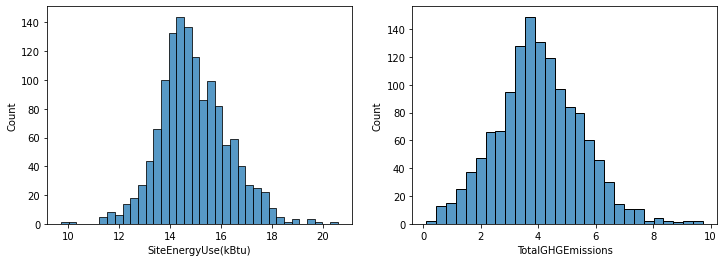

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

### Displays histogram of each log-transformed target
def target_distrib(targets):
    
    fig = plt.figure(figsize = (12,4))
    for i, target in enumerate(targets):
        g = fig.add_subplot(1,2,i+1)
        g = sns.histplot(target)
    
target_distrib([energy_target_train, co2_target_train])

The estimators will be trained the log-transformed targets.

## Pipelines

We will now set the Pipelines containing the estimators. These will include :
* appropriate encoders for categorical features
* a custom log-transformer for the size features
* a custom transformer for the energy source features 

### Encoding : categorical features

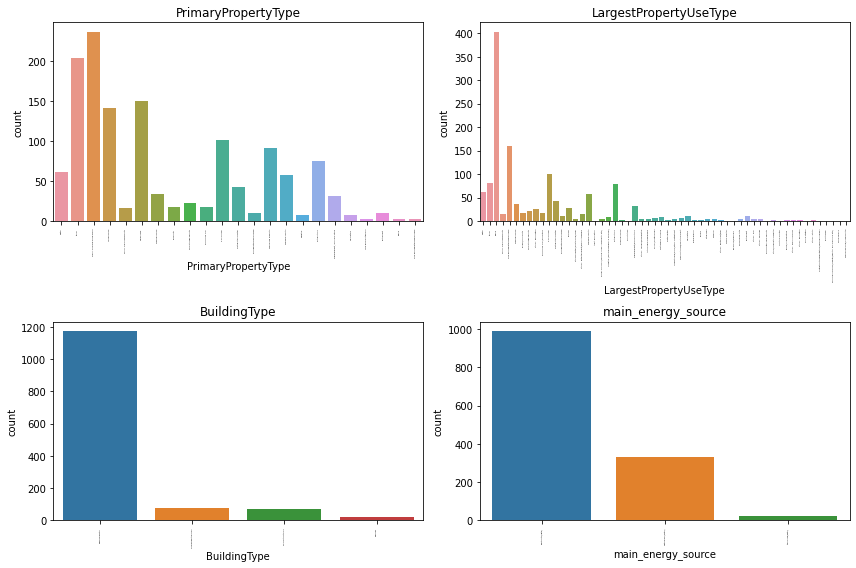

In [29]:
import seaborn as sns
from custom_transformer import Energy_variables_generator, log_transformer
import numpy as np
import matplotlib.pyplot as plt

### Displays count plots for each categorical feature
def cat_features_count_plots(data):
    
    data = data.copy()
    
    generator = Energy_variables_generator()
    data = generator.transform(data)
    
    cat_features = ['PrimaryPropertyType', 
    'LargestPropertyUseType', 'BuildingType', 
        'main_energy_source']
    
    fig = plt.figure(figsize = (12,8))
    
    for i, feature in enumerate(cat_features):
        g = fig.add_subplot(2,2,i+1)
        g = sns.countplot(x = feature, data = data)
        plt.xticks(fontsize= 2, rotation = 90)
        g.set_title(feature, fontsize = 12)
        
    fig.tight_layout()
    
cat_features_count_plots(X_train)

Comments:
* BuildingType & main_energy_source have a low number of classes (4 and 3). These two features are unordered since there is no induced order in the labels. One-hot-encoding may be a good option here since it will not create too many columns. Also one-hot-encoding is an unsupervised encoder (does not take into account the target values) which may prevent from overfitting.
* PrimaryPropertyType & LargestPropertyUseType have a pretty high number of categories. One-hot-encoding would lead to a great amount of sparse columns, which should be avoided. Target encoding seems an interesting solution. However a high number of classes, for a given number of samples, means that some categories are represented by a very few number of samples. Target encoding could lead in these cases to overfitting. This is why we will include a smoothing parameter that will produce a weighted-average between target value for each category and target mean value, to prevent again from overfitting. 

### Preprocessor

We will define here the preprocessing Pipelines corresponding to different groups of features. 
* The pipelines will be aggregated in a ColumnTransformer.
* It will be the prior step of the Pipeline before the estimators.

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import category_encoders as ce
from category_encoders import TargetEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


size_features =  ['NumberofBuildings', 'PropertyGFABuilding(s)', 
        'PropertyGFAParking',
       'NumberofFloors']


### Pipeline for size features with log-transformer
size_preprocessor = Pipeline([('imputer', SimpleImputer(strategy = 'median')), 
                ('log_transform', log_transformer()), 
                ('scaler', StandardScaler())])


### YearBuilt & ENERGYSTARScore
other_numeric_features = ['ENERGYSTARScore', 
        'YearBuilt']

other_numeric_preprocessor = Pipeline([('imputer', SimpleImputer(strategy = 'median')), 
                ('scaler', StandardScaler())])



### Pipeline for BuildingType categorical feature with onehotencoder
one_hot_cat_features = ['BuildingType']

one_hot_cat_preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
             ('one_hot', OneHotEncoder(use_cat_names=True)), 
              ('scaler', StandardScaler())])



### Pipeline for energy source features with onehotencoder
one_hot_source_features = ['Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)']

one_hot_source_preprocessor = Pipeline([
    ('features_generator', Energy_variables_generator()),
    ('one_hot', OneHotEncoder(use_cat_names=True)), 
              ('scaler', StandardScaler())])



### Pipeline for PrimaryPropertyType & LargestPropertyUseType categorical features 
### with TargetEncoder, smoothing = 1 (max)
target_encoding_features = ['PrimaryPropertyType', 
    'LargestPropertyUseType']

target_encoding_preprocessor = Pipeline([ 
                        ('encoding', TargetEncoder(smoothing = 1)), 
                        ('scaler', StandardScaler())])


### Meta-transformer ColumnTransformer driving columns to specified Pipeline
preprocessor = ColumnTransformer([('size_preprocessor', size_preprocessor, size_features),
            ('other_numeric_preprocessor', other_numeric_preprocessor, other_numeric_features),
                ('one_hot_cat_preprocessor', one_hot_cat_preprocessor, one_hot_cat_features),
                ('one_hot_source_preprocessor', one_hot_source_preprocessor, one_hot_source_features),
                ('target_encoding_preprocessor', target_encoding_preprocessor, 
                 target_encoding_features)])

### Estimators

We will train various estimators to compare their performance and chose the most performing.
* Linear estimators : LinearRegression, Lasso, SupportVectorMachines
* Non linear : RandomForest, Gradient Booosting
* Dummy regressor

In [31]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.dummy import DummyRegressor

### Preprocessor : first step of the pipeline

### Dummy
dummy = Pipeline([('preprocessor', preprocessor), ('dummy', DummyRegressor())])


#Random Forest
rf = Pipeline([('preprocessor', preprocessor), ('rf', RandomForestRegressor(random_state = 42))])


#XGBoost
xg = Pipeline([('preprocessor', preprocessor), ('xg', GradientBoostingRegressor(random_state = 42))])


#SVR
svr = Pipeline([('preprocessor', preprocessor), ('svr', SVR())])


# Lasso
lasso = Pipeline([('preprocessor', preprocessor), ('lasso', Lasso(random_state=42))])


# Linear Regression
lr = Pipeline([('preprocessor', preprocessor), ('lr', LinearRegression())])

## CV

We will compare in this step the estimators's performance on commonly used metrics for regression using Cross-validation method.

In [32]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, median_absolute_error,mean_squared_error 
from sklearn.model_selection import cross_validate

def cross_validation(estimators, data, target, metrics):
    
    data = data.copy()
    
    ### estimator names : estimators parameter takes list-of-tuple as value
    estimators_names = [name for name, estimator in estimators]
    
    ### estimators
    estimators = [estimator for name, estimator in estimators]
    
    ### cv_fold for reproducibility
    cv = KFold(n_splits= 5, shuffle = True, random_state=42)
    
    estimators_scores = {}
    ###Performs CV on each estimator
    for i, estimator in enumerate(estimators):
        estimator_scores = cross_validate(estimator = estimator, 
                X = data, y = target, cv = cv, scoring = metrics, 
            return_train_score=True)
        
        ### Creates estimator-name key in dictionary and set current estimator scores as value
        estimators_scores[estimators_names[i]] = estimator_scores
        
    
    ### add fit & score time to list of metrics 
    metrics = ['fit_time', 'score_time']  + ['test_' + metric for metric in metrics]
    folds = ['fold_' + str(i+1) for i in range(5)]
    
    fig = plt.figure(figsize = (16,16))
    ### one plot per metric
    for i, metric in enumerate(metrics):
        ax = fig.add_subplot(4,2,i+1)
        
        mean_scores = []
        for j, estimator_name in enumerate(estimators_names):
            
            ### Plots current estimator cv-scores on current metric
            ax.plot(estimators_scores[estimator_name][metric], 
            linestyle = 'dashed', label = estimator_name,
            marker = 'o', markersize = 10)
            
            mean_scores.append(np.mean(estimators_scores[estimator_name][metric]))
            
        ax.set_title(metric, fontsize = 20, pad = 16)
        ax.set_xticks(np.arange(0, 5, 1))
        ax.set_xticklabels(folds)
        
        ### Sort legend according to each estimator mean-score on cv folds on current metric
        handles, labels = ax.get_legend_handles_labels()
        
        handles, labels, score = zip(*sorted(zip(handles, labels, mean_scores), key = lambda k : k[2], 
                                reverse = True))
        
        ax.legend(handles, labels, fontsize = 7, bbox_to_anchor=(0, 1), loc='upper left', ncol=1,
                fancybox=True, framealpha=0.5)
        
    fig.tight_layout()
    
    return estimators_scores
        

### Scores on validation folds

We will test the estimators on various metrics

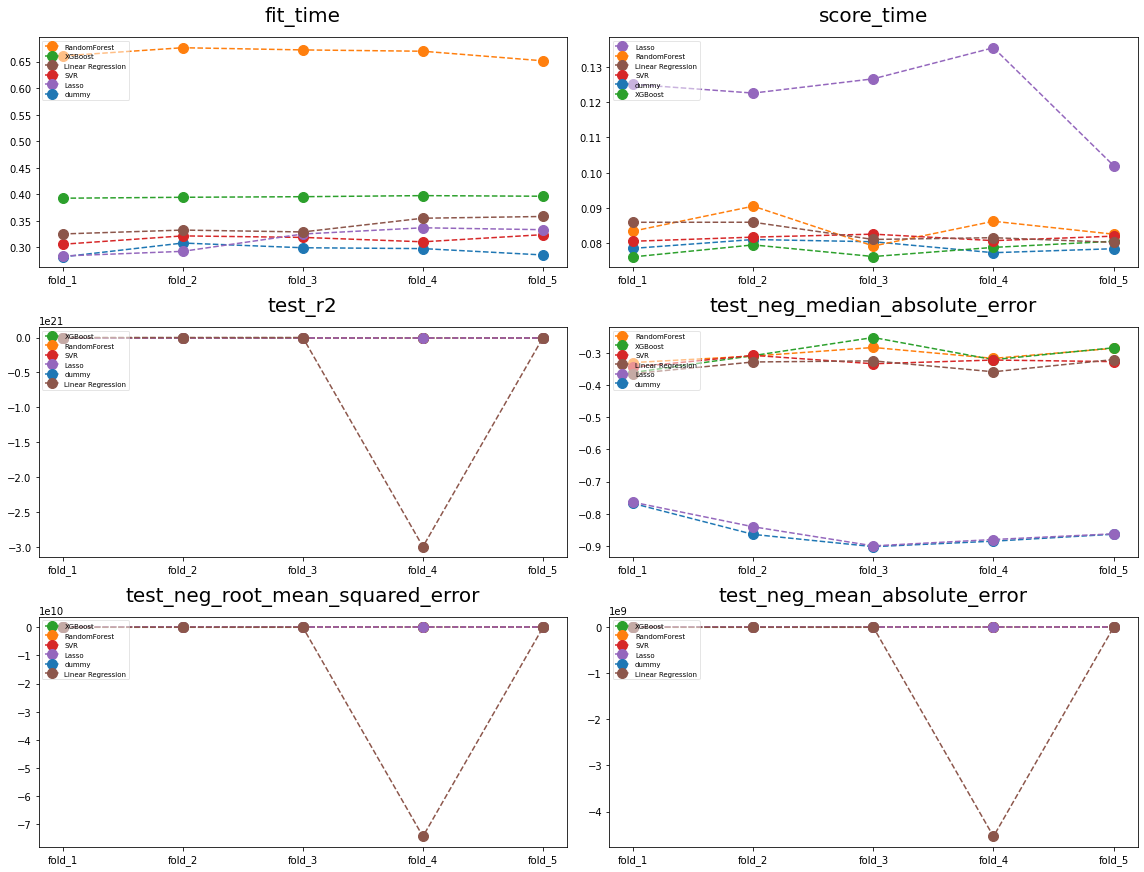

In [33]:
from sklearn.model_selection import StratifiedKFold

estimators = [('dummy', dummy), ('RandomForest', rf), 
         ('XGBoost', xg), 
          ('SVR', svr), 
          ('Lasso', lasso), 
        ('Linear Regression', lr)]

###
metrics = ['r2', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 
        'neg_mean_absolute_error']


estimators_scores = cross_validation(estimators, X_train, energy_target_train, metrics)

Linear Regression performance on fold_4 seems to be distorted by few badly-predicted samples, with a highly-negative value for R2. 
* This estimator is very sensitive to potential outliers, when fitting as well as when predicting. 
*Its score on median absolute error shows that its predictions are quite well centered though, with low bias, even if other estimators perform better. 

* However we will perform again this step excluding Linear Regression

In [ ]:
from sklearn.model_selection import StratifiedKFold

estimators = [('dummy', dummy), ('RandomForest', rf), 
         ('XGBoost', xg), 
          ('SVR', svr), 
          ('Lasso', lasso)]

###
metrics = ['r2', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 
        'neg_mean_absolute_error']


estimators_scores = cross_validation(estimators, X_train, energy_target_train, metrics)

Ensemble non linear models, XGBoost & RandomForest, are the most performing accross the selected metrics.
* Support Vector Machines also performs well.
* We will now see how these models tend to overfit when training by comparing their train/test scores. 

### CV train/validation scores

In [ ]:
import re
from re import search

def train_test_comparator(estimators_scores, metrics):
    
    
    ### empty df for concatenating in the loop
    df = pd.DataFrame()
    
    for estimator_name in estimators_scores:
        ### Creates df with current estimator scores stored as dict
        estimator_df = pd.DataFrame(estimators_scores[estimator_name])
        ### Creates column filled with estimator name
        estimator_df['model'] = estimator_name
        
        ### concatenate
        df = pd.concat([df,estimator_df])
        
    
    ### melt metric columns into single column
    df = pd.melt(df, id_vars = ['model', 'fit_time', 
            'score_time'], value_vars = df.drop(['model', 'fit_time', 
        'score_time'], axis=1).columns, var_name = 'metric', 
            value_name = 'score')
        
        
    fig = plt.figure(figsize = (16,12))
    
    for i, metric in enumerate(metrics):
        ### Filters dataframe on each metric before plotting
        mask = [bool(re.search(metric, value)) for value in df['metric']]
        filt_df = df[mask]
        
        ### Multiplies by (-1) the score values for 'neg' metrics 
        neg_mask = [bool(re.search('neg', value)) for value in filt_df['metric']]
        filt_df.loc[neg_mask, 'score'] = (-1)*filt_df.loc[neg_mask, 'score']
        
        
        g = fig.add_subplot(2,2,i+1)
        g = sns.barplot(x = 'model', y = 'score', hue = 'metric', 
            data = filt_df)
        g.set_title(metric, fontsize = 16, pad = 16)
        g.legend()
        fig.tight_layout()
        

    return df, neg_mask

In [ ]:
data, mask = train_test_comparator(estimators_scores, metrics)

RandomForest tends to perform better than XGBoost on training sets and quite less on validation sets.

### Optimizing best models:  XGBoost, RandomForest & SVR

We will now optimize the best three estimators: 
* XGBoost
* RandomForest
* SVR
* The metric on which the estimators will be optimized is R2. It is a scale-free metric, easy to interpret (the closer to 1 the better). Optimizing R2 is equivalent to optimizing RMSE or MSE.

### XGBoost

#### n_estimators

We will first the n_estimators parameter, which is an ensemble-wise parameter. 
* this parameter serves to prevent from overfitting as each tree is trained on its predecessor's errors
* Therefore a number too large of estimators would lead to overfitting, trying to predict essentially noise
* The optimal value for that parameter is dependent of learning_rate, which is here equal to 0.1

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'xg__n_estimators' : [20,30,40,50,60,70,80,90,100,110, 
                            120, 130, 140, 150]}

cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

grid = GridSearchCV(estimator = xg, param_grid = param_grid,
            scoring = 'r2', cv= cv)

grid.fit(X_train, energy_target_train)


print('Optimal number of estimators is ' + str(grid.best_params_))
print('Optimal score is ' + str(grid.best_score_))

The optimal n_estimators is higher than the standard value of 100 for this parameter. This suggests than the estimator was in under-fitting rather than over-fitting zone. The optimal parameter value is not at an extreme position of the grid so we may keep this result.

#### Tree hyper parameters

We will now optimize tree-level paramters.
* max_depth
* min samples in leaf
* min samples for split
* These HP should be optimized together because the optimal value for one paramter depends on the value of the others.
* We will optimize these paramters with RandomizedSearchCV, which tradeoffs quality of the solution versus computing time.
* However, selecting an optimal number of iterations allows to maximize the probability to reach a global optimum combination. 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {'xg__max_depth' : [1, 2, 3, 5, 7, 9], 
             'xg__min_samples_split': [2, 5,8,10,12,15,17, 19, 21, 23, 25, 27],
             'xg__min_samples_leaf': [1, 2, 3, 4, 5,6, 7, 8, 9, 10, 11, 12]}


### 60 is an optimal number of iterations to maximize the probability of reaching an optimum
### is the result of calculation made with Hyper-geometric law
grid_v2 = RandomizedSearchCV(estimator = grid.best_estimator_, param_distributions= 
                            param_distributions, scoring = 'r2',
                            cv = cv, n_iter = 60, random_state = 42)

grid_v2.fit(X_train, energy_target_train)


print('Optimal parameters are ' + str(grid_v2.best_params_))
print('Optimal score is ' + str(grid_v2.best_score_))
print('Precedent grid score is ' + str(grid.best_score_))

The optimal combination improves the precedent grid score, and all the HP are in middle positions in the grid. We may keep these HP for this step.

#### Samples/features

We can fix that only a portion of the samples will serve for fitting each tree, as well as a portion of the features. These parameters serve to prevent from overfitting.

In [ ]:
param_grid = {'xg__subsample' : [0.25, 0.5, 0.75, 0.9, 1], 
             'xg__max_features': ['auto', 'sqrt']}

grid_v3 = GridSearchCV(estimator = grid_v2.best_estimator_, param_grid= 
                            param_grid, scoring = 'r2',
                            cv = cv)

grid_v3.fit(X_train, energy_target_train)


print('Optimal number of estimators is ' + str(grid_v3.best_params_))
print('Optimal score is ' + str(grid_v3.best_score_))
print('grid_v3 score is ' + str(grid_v2.best_score_))
print('Standard score is ' + str(np.mean(estimators_scores['XGBoost']['test_r2'])))

Considering only half of the samples when growing each tree improves the overall performance of the estimator on the validation folds. It may have reduced overfitting of the estimator.

### Random Forest

#### Tree parameters

* Each tree grows independently in RandomForest, which means each added estimator would increase performance.
* Fixing the n_estimators parameter is generally done at the end of the process without using Grids.
* As for XGBoost, the tree-level parameters should be optimized jointly.

In [ ]:
param_distributions = {'rf__max_depth' : [3,5,7,9,11,13,15,17,19, 21, 23, 27], 
             'rf__min_samples_split': [2,5,10, 15, 19, 23, 27, 31, 35, 39],
             'rf__min_samples_leaf': [1, 2, 3, 5, 7, 9, 13]}

rf_grid = RandomizedSearchCV(estimator = rf, param_distributions= 
                            param_distributions, cv= cv, scoring = 'r2',
                            n_iter = 60, random_state=42)

rf_grid.fit(X_train, energy_target_train)

print('Optimal number of estimators is ' + str(rf_grid.best_params_))
print('Optimal score is ' + str(rf_grid.best_score_))
print('Standard score is ' + str(np.mean(estimators_scores['RandomForest']['test_r2'])))

As for XGBoost, the optimal combination improves the precedent grid score, and all the HP are in middle positions in the grid. We may keep these HP for this step.

#### Samples/features

As with XGBoost, we can fix that only a portion of the samples will serve for fitting each tree, as well as a portion of the features. These parameters serve to prevent from overfitting.

In [ ]:
param_grid = {'rf__max_samples' : [0.25,0.5,0.75,0.9,1], 
             'rf__max_features' : ['sqrt', 'auto']}

rf_grid_v2 = GridSearchCV(estimator = rf_grid.best_estimator_, param_grid= 
                            param_grid, cv= cv, scoring = 'r2')

rf_grid_v2.fit(X_train, energy_target_train)

print('Optimal parameters are ' + str(rf_grid_v2.best_params_))
print('Optimal score is ' + str(rf_grid_v2.best_score_))
print('Precedent grid best score is  ' + str(rf_grid.best_score_))
print('Standard score is ' + str(np.mean(estimators_scores['RandomForest']['test_r2'])))

The paramter values in the Grid do not help reducing overfitting of the model in this case. We may keep the standard values.

### SVR

We will optimize three hyperparameters for Support Vector Regressor.
* C : regularizatio parameter to prevent overfitting
* Gamma: kernel coefficients for 'rbf', 'sigmoid' and 'poly' transformation
* kernel :  type of transformation applied to the feature space before fitting the support vectors

In [ ]:
param_distributions = {'svr__C' : [0.001, 0.01, 0.1, 1, 10], 
             'svr__gamma' : [0.001, 0.01, 0.05, 0.1, 1], 
             'svr__kernel' : ['linear', 'poly', 'rbf', 'sigmoid']}

svr_grid = RandomizedSearchCV(estimator = svr, param_distributions= 
                            param_distributions, cv= cv, 
                scoring = 'r2', n_iter = 25, random_state=42)

svr_grid.fit(X_train, energy_target_train)

print('Optimal parameters are ' + str(svr_grid.best_params_))
print('Optimal score is ' + str(svr_grid.best_score_))
print('Standard score is ' + str(np.mean(estimators_scores['SVR']['test_r2'])))

The regularization parameter C optimization helped reducing overfitting and improve significantly the overall performance of the estimator.
* The optimal C value is inferior to the standard value (0.1 vs 1) which means stronger regularization was needed.
* Also a linear transformation of the feature space seems to be optimal in this case.

### Optimized vs non optimized estimators

We will compare the optimized estimators between them and with their standard versions to get insights on the gain realized through the optimization process.

In [ ]:
estimators = [('RandomForest', rf), 
              ('Optimized RandomForest', rf_grid.best_estimator_), 
         ('XGBoost', xg),
        ('Optimized XGBoost', grid_v3.best_estimator_),
        ('SVR', svr), 
            ('Optimized SVR', svr_grid.best_estimator_)]

metrics = ['r2', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 
        'neg_mean_absolute_error']


estimators_scores = cross_validation(estimators, X_train, energy_target_train, metrics)

The optimized XGBoost is our best estimator. It performs better than the others accross different metrics, ie on R2 as well as median_absolute_error.

### Choice : XGBoost

We will now realize a last optimization stage for XGBoost to get the best possible performance on test set. 

#### Loss function

Loss function when fitting a split on a node.

In [ ]:
param_grid = {'xg__loss' : ['ls', 'lad', 'huber', 'quantile']}

grid_v4 = GridSearchCV(estimator = grid_v3.best_estimator_, param_grid= 
                            param_grid, scoring = 'r2',
                            cv = cv)

grid_v4.fit(X_train, energy_target_train)


print('Optimal parameters are ' + str(grid_v4.best_params_))
print('Optimal score is ' + str(grid_v4.best_score_))
print('Precedent grid score is ' + str(grid_v3.best_score_))

The optimal value is the standard value for cost function : 'ls' for least squares.

#### Lowering leaning rate

Lowering learning rate can help get more robust models. The n_estimators should be modified proportionally to the decrease of learning_rate.

In [ ]:
param_grid = [{'xg__learning_rate' : [0.01], 'xg__n_estimators' : [1400]}, 
    {'xg__learning_rate' : [0.02], 'xg__n_estimators' : [700]},
    {'xg__learning_rate' : [0.03], 'xg__n_estimators' : [int(140*0.1/0.03)]}, 
   {'xg__learning_rate' : [0.04], 'xg__n_estimators' : [350]}, 
   {'xg__learning_rate' : [0.05], 'xg__n_estimators' : [280]}, 
  {'xg__learning_rate' : [0.06], 'xg__n_estimators' : [int(140*0.1/0.06)]}, 
{'xg__learning_rate' : [0.07], 'xg__n_estimators' : [200]},
{'xg__learning_rate' : [0.08], 'xg__n_estimators' : [175]},
{'xg__learning_rate' : [0.09], 'xg__n_estimators' : [int(140*0.11/0.09)]}, 
{'xg__learning_rate' : [0.1], 'xg__n_estimators' : [140]}]
              
grid_v5 = GridSearchCV(estimator = grid_v3.best_estimator_, param_grid= 
                            param_grid, scoring = 'r2',
                            cv = cv)

grid_v5.fit(X_train, energy_target_train)


print('Optimal parameters are ' + str(grid_v5.best_params_))
print('Optimal score is ' + str(grid_v5.best_score_))
print('Precedent grid score is ' + str(grid_v3.best_score_))

#### XGBoosts comparison

Comparing the three XGBoosts'(standard, optimized & best) performance on the metrics using cross-validation.

In [ ]:
estimators = [ 
         ('XGBoost', xg),
    ('Optimized XGBoost', grid_v3.best_estimator_), 
    ('Best XGBoost', grid_v5.best_estimator_)]

metrics = ['r2']


estimators_scores = cross_validation(estimators, X_train, energy_target_train, metrics)

## Test set : predictions

In [ ]:
def predictions(y_true):
    estimator = grid_v5.best_estimator_
        
    model = estimator.fit(X_train, energy_target_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_true, y_pred)

    valid_r2 = np.mean(estimators_scores['Best XGBoost']['test_r2'])
    train_r2 = np.mean(estimators_scores['Best XGBoost']['train_r2'])

    print('r2 score on test set is ' + str(r2))
    print('mean r2 score on validation sets is ' + str(valid_r2))
    print('mean r2 score on train sets is ' + str(train_r2))


    fig = plt.figure(figsize = (7,6))
    ax = fig.add_subplot(111)

    ax.bar(x = np.arange(0,3,1), height = [train_r2, valid_r2, r2],
        width = 0.8)
    ax.set_title('Train/validation/test R2 scores', fontsize = 16, pad = 16)
    ax.set_xticks(np.arange(0,3,1))
    ax.set_xticklabels(['Train', 'Validation', 'Test'], fontsize = 12)
    ax.set_ylabel('R2', fontsize = 14)
    
    return y_pred

In [ ]:
y_pred = predictions(energy_target_test)

### Visualizing predictions

In [ ]:
def visualizing_pred(y_true, y_pred):

    fig, ax = plt.subplots(1, 1, figsize = (9,6))

    ax.scatter(x = y_true, y = y_pred)
    ax.plot([np.min(y_true), np.max(y_true)], [np.min(y_true), np.max(y_true)], 
        linewidth = 5)
    ax.set_xlabel('Actual', fontsize = 20)
    ax.set_ylabel('Predicted', fontsize = 20)
    ax.set_title('Actual vs predictions', fontsize = 24)
    #ax.scatter(x = target_1_test, y = target_1_test, color = 'blue', linewidth = 0.01)


In [ ]:
visualizing_pred(energy_target_test, y_pred)

* The overall impression is that observations are pretty well centered accross the two sides of the line.
* However we can see that the samples with lowest values on target have prediction values higher than expected and may reduce the score.

### Prediction score by building type

We will now visualize the score of the predictions per each building type category.

In [ ]:
def predictions_per_building_type(y_true,y_pred, X_test):
    
    scores = []
    
    for i, building_type in enumerate(X_test['BuildingType'].unique()):
        pred = y_pred[X_test['BuildingType'] == building_type]
        actual = y_true[X_test['BuildingType'] == building_type]
        r2 = r2_score(actual, pred)
        
        scores.append(r2)
        
    palette = sns.color_palette(n_colors=4)
    fig = plt.figure(figsize = (9,6))
    
    ax = fig.add_subplot(111)
    ax.bar(x = np.arange(0,4,1), height = scores, 
        width = 0.8, color = palette)
    ax.set_xticks(np.arange(0,4,1))
    ax.set_xticklabels(X_test['BuildingType'].unique(), fontsize = 12)
    ax.set_title('Score per building type', fontsize = 16, pad = 16)
    ax.set_ylabel('R2 score', fontsize = 14)
    ax.set_xlabel('Building Type', fontsize = 14)
    
predictions_per_building_type(energy_target_test, y_pred, X_test)

* The score of predictions on the most represented category is pretty equal to the overall score.
* The model is less accurate on predicting NonresidentialCOS buildings.

## Total GHGE Emissions target

We will now train the optimized XGBoost estimator on the CO2 emissions target and make predictions on the test set.

### Training & predictions on

In [ ]:
def co2_predictions(y_true):
    
    estimator = grid_v5.best_estimator_
    model = estimator.fit(X_train, co2_target_train)
    
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_true, y_pred)
    
    print('r2 score on test set is ' + str(r2))
    
    return y_pred, model

In [ ]:
co2_y_pred, co2_model = co2_predictions(co2_target_test)

The r2 score on the test set is even better than for the energy consumption target. This confirms our assumption that the same set of features would be helpful to predict both targets, given the highly positive linear correlation between targets.

### Visualizing predictions

In [ ]:
visualizing_pred(co2_target_test, co2_y_pred)

* The plot confirms the high score on predictions.
* As for the energy consumption target, some of the samples with lowest values on the target are overpredicted by the model.

### CO2 predictions per building type

In [ ]:
predictions_per_building_type(co2_target_test, co2_y_pred, X_test)

* As for the energy consumption target, the score of predictions on the most represented category is pretty equal to the overall score.
* The model is more accurate to predict CO2 emissions of NonresidentialCOS buildings than their energy consumption value.

## Feature importances

In [ ]:

### Displays feature importances for best XGBoost 
def feature_importances(model):
    
    features = size_features.copy()
    
    features.extend(other_numeric_features)
    
    features.extend(['BuildingType_NonResidential', 'BuildingType_Nonresidential COS',
       'BuildingType_SPS-District K-12', 'BuildingType_Campus'])
    
    
    features.extend(['main_energy_source_Electricity(kBtu)',
       'main_energy_source_NaturalGas(kBtu)',
       'main_energy_source_SteamUse(kBtu)', 'Electricity(kBtu)_use',
       'NaturalGas(kBtu)_use', 'SteamUse(kBtu)_use'])
    
    features.extend(target_encoding_features)
    
    feature_importances = model.named_steps['xg'].feature_importances_
    
    
    fig = plt.figure(figsize = (5,7))
    
    ax = fig.add_subplot(111)
    
    ax.barh(y = np.arange(0,len(features),1), width = sorted(feature_importances), 
        height = 0.8)
    
    labels, _ = zip(*sorted(zip(features, feature_importances), 
                        key = lambda k : k[1]))
    
    ax.set_yticks(np.arange(0,len(features),1))
    ax.set_yticklabels(labels, fontsize = 8)
    ax.set_ylabel('Features', fontsize = 14)
    ax.set_title('Feature importances', fontsize=16, pad=16)

### Energy consumption

In [ ]:
feature_importances(grid_v3.best_estimator_)

### CO2 emissions

In [ ]:
feature_importances(co2_model)

Comments : 
* Property GFA Building is by far the most important feature to predict both targets. It is the feature that generates most of the splits whrn growing the trees. 
* Building type features are also relevant.
* Energy source features are more relevant to predict CO2 emissions than energy consumption.

# Conclusion

* We achieved estimating robust and generalizable models to predict both energy consumption & co2 emissions targets. 
* The features of the data are relevant, as various estimators could achieve a solid performance on most commonnly used metrics t avluate the quality of a regression
* An optimized version of XGBoost is the most performing among all the estimators we tested in this workflow.
* By far the most important feature is the size of the buildings for both targets, even though Energy sources and building type also proved useful.
* Further research may add relevant features, do more feature engineering and try other estimators too.